In [1]:
%load_ext watermark


In [2]:
import boto3
import botocore
from io import StringIO
from iterdub import iterdub as ib
from iterpop import iterpop as ip
from matplotlib import pyplot as plt
import pandas as pd
from pandas.util import hash_pandas_object
import re
import seaborn as sns
import statsmodels.api as sm
from teeplot import teeplot as tp


In [3]:
import os

from IPython.display import display
import seaborn as sns
from teeplot import teeplot as tp

from dishpylib.pyhelpers import make_outattr_metadata
from dishpylib.pyhelpers import print_runtime


In [4]:
%watermark -diwmuv -iv


Last updated: 2025-09-08T04:51:50.027349+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.16.1

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.8.0-1031-azure
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

teeplot    : 1.4.2
boto3      : 1.14.44
iterdub    : 0.2.0
botocore   : 1.17.44
re         : 2.2.1
statsmodels: 0.13.5
seaborn    : 0.13.2
pandas     : 1.4.4
iterpop    : 0.3.4
matplotlib : 3.5.3

Watermark: 2.4.3



In [5]:
teeplot_subdir = os.environ.get(
    "NOTEBOOK_NAME", "2025-08-28-complexity-adaptation"
)
teeplot_subdir


'2025-08-28-complexity-adaptation'

# get data


In [6]:
s3_handle = boto3.resource(
    's3',
    region_name="us-east-2",
    config=botocore.config.Config(
        signature_version=botocore.UNSIGNED,
    ),
)
bucket_handle = s3_handle.Bucket('prq49')

series_profiles, = bucket_handle.objects.filter(
    Prefix=f'endeavor=16/series-profiles/stage=8+what=elaborated/',
)


In [7]:
df = pd.read_csv(
    f's3://prq49/{series_profiles.key}',
    compression='xz',
)
dfdigest = '{:x}'.format(hash_pandas_object( df ).sum())
dfdigest


<ipython-input-7-06b399353b17>:1: DtypeWarning: Columns (2270,2277,2284,2285,2286,2287,2289,2290,2291,2292,2298,2299,2300,2301,2302,2308,2309,2310) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


'-1af9f0eb89153a8e'

# set up graphing utilities


In [8]:
def letterscatter(*,data,x,y,cat):
    sns.scatterplot(
        data=data,
        x=x,
        y=y,
        color='k',
        edgecolor='k',
        s=200,
    )
    sns.scatterplot(
        data=data,
        x=x,
        y=y,
        hue=cat,
        edgecolor=None,
        s=120,
    )
    sns.scatterplot(
        data=data,
        x=x,
        y=y,
        color='w',
        style=cat,
        markers={
            phen : f'$\mathrm{{{phen}}}$'
            for phen in data[cat].unique()
        },
        legend=False,
    )
    plt.legend(
        bbox_to_anchor=(1.01, 1),
        borderaxespad=0,
        title='Morph',
        frameon=False,
    )


In [9]:
def letterscatter_vline(*args, **kwargs):
    letterscatter(*args, **kwargs)
    plt.axvline(15,zorder=-2,c='k',ls=':')
    plt.axvline(45,zorder=-2,c='k',ls='--')


In [10]:
def letterscatter_vline_interpolationmissing(*args, **kwargs):
    letterscatter_vline(*args, **kwargs)

    for stint in dfx[ dfx['a=most_credible_idx+set_size=1'].isnull() ]['Stint']:
        plt.axvline(stint, c='gray', zorder=-2, alpha=0.5)


# preprocess data


In [11]:
morph_csv = StringIO('''Stint,Morph,Series
0,a,16005
1,b,16005
2,c,16005
3,b,16005
4,b,16005
5,b,16005
6,b,16005
7,b,16005
8,b,16005
9,b,16005
10,b,16005
11,b,16005
12,b,16005
13,b,16005
14,d,16005
15,e,16005
16,e,16005
17,e,16005
18,e,16005
19,e,16005
20,e,16005
21,e,16005
22,e,16005
23,e,16005
24,e,16005
25,e,16005
26,b,16005
27,e,16005
28,b,16005
29,e,16005
30,e,16005
31,e,16005
32,e,16005
33,e,16005
34,e,16005
35,e,16005
36,e,16005
37,e,16005
38,e,16005
39,f,16005
40,e,16005
41,e,16005
42,e,16005
43,e,16005
44,e,16005
45,g,16005
46,g,16005
47,g,16005
48,g,16005
49,g,16005
50,g,16005
51,g,16005
52,g,16005
53,e,16005
54,g,16005
55,g,16005
56,g,16005
57,g,16005
58,g,16005
59,h,16005
60,g,16005
61,e,16005
62,g,16005
63,g,16005
64,e,16005
65,e,16005
66,g,16005
67,g,16005
68,e,16005
69,g,16005
70,e,16005
71,e,16005
72,e,16005
73,g,16005
74,i,16005
75,i,16005
76,g,16005
77,i,16005
78,e,16005
79,g,16005
80,e,16005
81,e,16005
82,e,16005
83,e,16005
84,e,16005
85,e,16005
86,e,16005
87,e,16005
88,e,16005
89,g,16005
90,g,16005
91,e,16005
92,i,16005
93,e,16005
94,e,16005
95,b,16005
96,b,16005
97,h,16005
98,e,16005
99,e,16005
100,j,16005
''')

df_morph = pd.read_csv(morph_csv)


In [12]:
df = pd.merge(
    df,
    df_morph,
    on=['Stint', 'Series'],
    how='outer',
)


In [13]:
lowestroot_phylo_csv = StringIO('''proc,thread,Stint,Series,Lowest Num Stint Root IDs,Lowest Root ID
0,0,0,16005,1,2378
0,1,0,16005,1,2378
0,2,0,16005,1,2378
0,3,0,16005,1,2378
0,0,100,16005,25,12634
0,1,100,16005,26,12634
0,2,100,16005,24,12634
0,3,100,16005,22,12634
0,0,10,16005,4,12634
0,1,10,16005,3,12634
0,2,10,16005,4,12634
0,3,10,16005,3,12634
0,0,11,16005,3,12634
0,1,11,16005,3,12634
0,2,11,16005,2,12634
0,3,11,16005,3,12634
0,0,12,16005,4,12634
0,1,12,16005,4,12634
0,2,12,16005,4,12634
0,3,12,16005,4,12634
0,0,13,16005,2,12634
0,1,13,16005,2,12634
0,2,13,16005,2,12634
0,3,13,16005,2,12634
0,0,14,16005,3,12634
0,1,14,16005,3,12634
0,2,14,16005,3,12634
0,3,14,16005,3,12634
0,0,15,16005,3,12634
0,1,15,16005,4,12634
0,2,15,16005,4,12634
0,3,15,16005,4,12634
0,0,16,16005,4,12634
0,1,16,16005,3,12634
0,2,16,16005,3,12634
0,3,16,16005,2,12634
0,0,17,16005,9,12634
0,1,17,16005,5,12634
0,2,17,16005,5,12634
0,3,17,16005,3,12634
0,0,18,16005,7,12634
0,1,18,16005,7,12634
0,2,18,16005,3,12634
0,3,18,16005,6,12634
0,0,19,16005,8,12634
0,1,19,16005,11,12634
0,2,19,16005,6,12634
0,3,19,16005,7,12634
0,0,1,16005,1,2378
0,1,1,16005,1,2378
0,2,1,16005,1,2378
0,3,1,16005,2,2378
0,0,20,16005,8,12634
0,1,20,16005,9,12634
0,2,20,16005,9,12634
0,3,20,16005,11,12634
0,0,21,16005,10,12634
0,1,21,16005,9,12634
0,2,21,16005,11,12634
0,3,21,16005,6,12634
0,0,22,16005,11,12634
0,1,22,16005,10,12634
0,2,22,16005,8,12634
0,3,22,16005,10,12634
0,0,23,16005,7,12634
0,1,23,16005,10,12634
0,2,23,16005,15,12634
0,3,23,16005,13,12634
0,0,24,16005,10,12634
0,1,24,16005,5,12634
0,2,24,16005,13,12634
0,3,24,16005,7,12634
0,0,25,16005,13,12634
0,1,25,16005,15,12634
0,2,25,16005,5,12634
0,3,25,16005,9,12634
0,0,26,16005,6,12634
0,1,26,16005,6,12634
0,2,26,16005,7,12634
0,3,26,16005,8,12634
0,0,27,16005,11,12634
0,1,27,16005,9,12634
0,2,27,16005,9,12634
0,3,27,16005,6,12634
0,0,28,16005,8,12634
0,1,28,16005,6,12634
0,2,28,16005,13,12634
0,3,28,16005,9,12634
0,0,29,16005,7,12634
0,1,29,16005,8,12634
0,2,29,16005,9,12634
0,3,29,16005,10,12634
0,0,2,16005,2,12634
0,1,2,16005,3,12634
0,2,2,16005,2,12634
0,3,2,16005,2,12634
0,0,30,16005,10,12634
0,1,30,16005,10,12634
0,2,30,16005,16,12634
0,3,30,16005,11,12634
0,0,31,16005,11,12634
0,1,31,16005,12,12634
0,2,31,16005,9,12634
0,3,31,16005,12,12634
0,0,32,16005,10,12634
0,1,32,16005,9,12634
0,2,32,16005,14,12634
0,3,32,16005,15,12634
0,0,33,16005,12,12634
0,1,33,16005,18,12634
0,2,33,16005,13,12634
0,3,33,16005,19,12634
0,0,34,16005,23,12634
0,1,34,16005,25,12634
0,2,34,16005,17,12634
0,3,34,16005,22,12634
0,0,35,16005,13,12634
0,1,35,16005,15,12634
0,2,35,16005,14,12634
0,3,35,16005,13,12634
0,0,36,16005,13,12634
0,1,36,16005,17,12634
0,2,36,16005,16,12634
0,3,36,16005,23,12634
0,0,37,16005,8,12634
0,1,37,16005,12,12634
0,2,37,16005,9,12634
0,3,37,16005,17,12634
0,0,38,16005,16,12634
0,1,38,16005,16,12634
0,2,38,16005,18,12634
0,3,38,16005,15,12634
0,0,39,16005,19,12634
0,1,39,16005,21,12634
0,2,39,16005,10,12634
0,3,39,16005,14,12634
0,0,3,16005,6,12634
0,1,3,16005,6,12634
0,2,3,16005,4,12634
0,3,3,16005,7,12634
0,0,40,16005,16,12634
0,1,40,16005,15,12634
0,2,40,16005,17,12634
0,3,40,16005,17,12634
0,0,41,16005,18,12634
0,1,41,16005,19,12634
0,2,41,16005,26,12634
0,3,41,16005,20,12634
0,0,42,16005,18,12634
0,1,42,16005,17,12634
0,2,42,16005,16,12634
0,3,42,16005,12,12634
0,0,43,16005,22,12634
0,1,43,16005,26,12634
0,2,43,16005,18,12634
0,3,43,16005,18,12634
0,0,44,16005,20,12634
0,1,44,16005,14,12634
0,2,44,16005,17,12634
0,3,44,16005,13,12634
0,0,45,16005,8,12634
0,1,45,16005,17,12634
0,2,45,16005,14,12634
0,3,45,16005,18,12634
0,0,46,16005,14,12634
0,1,46,16005,16,12634
0,2,46,16005,14,12634
0,3,46,16005,16,12634
0,0,47,16005,11,12634
0,1,47,16005,11,12634
0,2,47,16005,16,12634
0,3,47,16005,25,12634
0,0,48,16005,12,12634
0,1,48,16005,17,12634
0,2,48,16005,15,12634
0,3,48,16005,15,12634
0,0,49,16005,13,12634
0,1,49,16005,11,12634
0,2,49,16005,13,12634
0,3,49,16005,15,12634
0,0,4,16005,5,12634
0,1,4,16005,4,12634
0,2,4,16005,3,12634
0,3,4,16005,5,12634
0,0,50,16005,15,12634
0,1,50,16005,13,12634
0,2,50,16005,12,12634
0,3,50,16005,11,12634
0,0,51,16005,13,12634
0,1,51,16005,14,12634
0,2,51,16005,9,12634
0,3,51,16005,11,12634
0,0,52,16005,24,12634
0,1,52,16005,14,12634
0,2,52,16005,15,12634
0,3,52,16005,21,12634
0,0,53,16005,17,12634
0,1,53,16005,13,12634
0,2,53,16005,16,12634
0,3,53,16005,21,12634
0,0,54,16005,12,12634
0,1,54,16005,12,12634
0,2,54,16005,13,12634
0,3,54,16005,14,12634
0,0,55,16005,14,12634
0,1,55,16005,11,12634
0,2,55,16005,12,12634
0,3,55,16005,17,12634
0,0,56,16005,12,12634
0,1,56,16005,19,12634
0,2,56,16005,13,12634
0,3,56,16005,15,12634
0,0,57,16005,24,12634
0,1,57,16005,23,12634
0,2,57,16005,20,12634
0,3,57,16005,19,12634
0,0,58,16005,17,12634
0,1,58,16005,17,12634
0,2,58,16005,17,12634
0,3,58,16005,16,12634
0,0,59,16005,18,12634
0,1,59,16005,13,12634
0,2,59,16005,13,12634
0,3,59,16005,12,12634
0,0,5,16005,5,12634
0,1,5,16005,6,12634
0,2,5,16005,6,12634
0,3,5,16005,6,12634
0,0,60,16005,20,12634
0,1,60,16005,19,12634
0,2,60,16005,18,12634
0,3,60,16005,20,12634
0,0,61,16005,14,12634
0,1,61,16005,16,12634
0,2,61,16005,9,12634
0,3,61,16005,14,12634
0,0,62,16005,12,12634
0,1,62,16005,11,12634
0,2,62,16005,10,12634
0,3,62,16005,15,12634
0,0,63,16005,12,12634
0,1,63,16005,13,12634
0,2,63,16005,13,12634
0,3,63,16005,15,12634
0,0,64,16005,14,12634
0,1,64,16005,13,12634
0,2,64,16005,11,12634
0,3,64,16005,10,12634
0,0,65,16005,12,12634
0,1,65,16005,15,12634
0,2,65,16005,13,12634
0,3,65,16005,13,12634
0,0,66,16005,16,12634
0,1,66,16005,15,12634
0,2,66,16005,17,12634
0,3,66,16005,13,12634
0,0,67,16005,10,12634
0,1,67,16005,8,12634
0,2,67,16005,6,12634
0,3,67,16005,11,12634
0,0,68,16005,8,12634
0,1,68,16005,10,12634
0,2,68,16005,12,12634
0,3,68,16005,10,12634
0,0,69,16005,9,12634
0,1,69,16005,11,12634
0,2,69,16005,9,12634
0,3,69,16005,9,12634
0,0,6,16005,4,12634
0,1,6,16005,3,12634
0,2,6,16005,4,12634
0,3,6,16005,4,12634
0,0,70,16005,13,12634
0,1,70,16005,16,12634
0,2,70,16005,13,12634
0,3,70,16005,16,12634
0,0,71,16005,17,12634
0,1,71,16005,18,12634
0,2,71,16005,18,12634
0,3,71,16005,18,12634
0,0,72,16005,16,12634
0,1,72,16005,15,12634
0,2,72,16005,16,12634
0,3,72,16005,18,12634
0,0,73,16005,17,12634
0,1,73,16005,19,12634
0,2,73,16005,15,12634
0,3,73,16005,21,12634
0,0,74,16005,17,12634
0,1,74,16005,21,12634
0,2,74,16005,17,12634
0,3,74,16005,22,12634
0,0,75,16005,13,12634
0,1,75,16005,12,12634
0,2,75,16005,15,12634
0,3,75,16005,14,12634
0,0,76,16005,14,12634
0,1,76,16005,15,12634
0,2,76,16005,16,12634
0,3,76,16005,20,12634
0,0,77,16005,9,12634
0,1,77,16005,9,12634
0,2,77,16005,13,12634
0,3,77,16005,12,12634
0,0,78,16005,14,12634
0,1,78,16005,12,12634
0,2,78,16005,13,12634
0,3,78,16005,12,12634
0,0,79,16005,16,12634
0,1,79,16005,21,12634
0,2,79,16005,22,12634
0,3,79,16005,21,12634
0,0,7,16005,4,12634
0,1,7,16005,4,12634
0,2,7,16005,5,12634
0,3,7,16005,5,12634
0,0,80,16005,14,12634
0,1,80,16005,12,12634
0,2,80,16005,11,12634
0,3,80,16005,12,12634
0,0,81,16005,13,12634
0,1,81,16005,17,12634
0,2,81,16005,21,12634
0,3,81,16005,17,12634
0,0,82,16005,16,12634
0,1,82,16005,17,12634
0,2,82,16005,18,12634
0,3,82,16005,13,12634
0,0,83,16005,12,12634
0,1,83,16005,16,12634
0,2,83,16005,12,12634
0,3,83,16005,11,12634
0,0,84,16005,19,12634
0,1,84,16005,17,12634
0,2,84,16005,12,12634
0,3,84,16005,14,12634
0,0,85,16005,11,12634
0,1,85,16005,17,12634
0,2,85,16005,18,12634
0,3,85,16005,19,12634
0,0,86,16005,16,12634
0,1,86,16005,22,12634
0,2,86,16005,14,12634
0,3,86,16005,18,12634
0,0,87,16005,17,12634
0,1,87,16005,16,12634
0,2,87,16005,15,12634
0,3,87,16005,15,12634
0,0,88,16005,14,12634
0,1,88,16005,12,12634
0,2,88,16005,15,12634
0,3,88,16005,10,12634
0,0,89,16005,15,12634
0,1,89,16005,14,12634
0,2,89,16005,14,12634
0,3,89,16005,16,12634
0,0,8,16005,3,12634
0,1,8,16005,3,12634
0,2,8,16005,4,12634
0,3,8,16005,4,12634
0,0,90,16005,19,12634
0,1,90,16005,17,12634
0,2,90,16005,11,12634
0,3,90,16005,8,12634
0,0,91,16005,16,12634
0,1,91,16005,17,12634
0,2,91,16005,15,12634
0,3,91,16005,18,12634
0,0,92,16005,10,12634
0,1,92,16005,12,12634
0,2,92,16005,17,12634
0,3,92,16005,19,12634
0,0,93,16005,7,12634
0,1,93,16005,5,12634
0,2,93,16005,11,12634
0,3,93,16005,4,12634
0,0,94,16005,17,12634
0,1,94,16005,12,12634
0,2,94,16005,20,12634
0,3,94,16005,18,12634
0,0,95,16005,12,12634
0,1,95,16005,12,12634
0,2,95,16005,16,12634
0,3,95,16005,19,12634
0,0,96,16005,14,12634
0,1,96,16005,17,12634
0,2,96,16005,16,12634
0,3,96,16005,11,12634
0,0,97,16005,10,12634
0,1,97,16005,10,12634
0,2,97,16005,15,12634
0,3,97,16005,11,12634
0,0,98,16005,17,12634
0,1,98,16005,17,12634
0,2,98,16005,21,12634
0,3,98,16005,16,12634
0,0,99,16005,19,12634
0,1,99,16005,15,12634
0,2,99,16005,21,12634
0,3,99,16005,15,12634
0,0,9,16005,6,12634
0,1,9,16005,5,12634
0,2,9,16005,3,12634
0,3,9,16005,5,12634
''')

df_lowestroot_phylo = pd.read_csv(lowestroot_phylo_csv).groupby([
    'Series',
    'Stint',
]).mean().reset_index()


In [14]:
df = pd.merge(
    df,
    df_lowestroot_phylo,
    on=['Stint', 'Series'],
    how='outer',
)


In [15]:
dfm10 = df[ df['Stint'] % 10 == 0 ]


In [16]:
dfx = df[ df['Series'] == 16005 ].sort_values('Morph')


In [17]:
for col in df.columns:
    print(col)


Repro
Endeavor
Slurm Job ID
N_THREADS
RUN
RUN_UPDATES
RUN_SECONDS
MAIN_TIMEOUT_SECONDS
END_SNAPSHOT_TIMEOUT_SECONDS
LOG_FREQ
ASYNCHRONOUS
SYNC_FREQ_MILLISECONDS
RNG_PRESEED
THROW_ON_EXTINCTION
RUN_SLUG
PHENOTYPIC_DIVERGENCE_N_UPDATES
PHENOTYPIC_DIVERGENCE_N_CELLS
STINT
SERIES
REPLICATE
TREATMENT
SEED_FILL_FRACTION
GENESIS
N_CELLS
WEAK_SCALING
N_DIMS
GROUP_EXPIRATION_DURATIONS
CELL_AGE_DURATION
MIN_START_RESOURCE
MAX_START_RESOURCE
RESOURCE_DECAY
APOP_RECOVERY_FRAC
SPAWN_DEFENSE_COST
BASE_HARVEST_RATE
COLLECTIVE_HARVEST_RATE
OPTIMAL_QUORUM_COUNT
P_SET_QUORUM_BIT
QUORUM_CAP
P_QUORUM_CAP_KILL
PROGRAM_START_SIZE
PROGRAM_MAX_SIZE
MUTATION_RATE
POINT_MUTATION_RATE
SEQUENCE_DEFECT_RATE
MINOR_SEQUENCE_MUTATION_BOUND
SEVERE_SEQUENCE_MUTATION_RATE
HARDWARE_EXECUTION_ROUNDS
HARDWARE_EXECUTION_CYCLES
CONTROLLER_MAPPED_STATE_DEFECT_RATE
APOPTOSIS_SERVICE_FREQUENCY
BIRTH_SETUP_SERVICE_FREQUENCY
CELL_AGE_SERVICE_FREQUENCY
CONDUIT_FLUSH_SERVICE_FREQUENCY
COLLECTIVE_HARVESTING_SERVICE_FREQUENCY
CPU_EXE

## Fitness Data


In [18]:
background_key = {
    "immediatepredecessor-simuls-dosecorrected-withbioticbackground-withmut"
        : "Prefatory",
    "immediatepredecessor-simuls-dosecorrected-withfuturebioticbackground-withmut"
        : "Contemporary",
    "immediatepredecessor-simuls-nobioticbackground-withmut"
        : "Without",
    "lowestroot-immediatepredecessor-battles"
        : "Without",
    "immediatepredecessor-simuls-dosecorrected-nodiversitymaintenance-withbioticbackground-withmut"
        : "Prefatory\n(no diversity maint.)",
    "immediatepredecessor-simuls-dosecorrected-nodiversitymaintenance-withfuturebioticbackground-withmut"
        : "Contemporary\n(no diversity maint.)",
    "immediatepredecessor-battles-dosecorrected-withbioticbackground-withmut"
        : "Prefatory",
    "immediatepredecessor-battles-dosecorrected-withfuturebioticbackground-withmut"
        : "Contemporary",
}


In [19]:
color_key = {
    'a' : 'tab:blue',
    'b' : 'tab:orange',
    'c' : 'tab:green',
    'd' : 'tab:red',
    'e' : 'tab:purple',
    'f' : 'tab:brown',
    'g' : 'tab:pink',
    'h' : 'tab:gray',
    'i' : 'tab:olive',
    'j' : 'tab:cyan',
}


In [20]:
morph_key = {
    row['Stint'] : row['Morph']
    for idx, row in df_morph.iterrows()
}


In [21]:
def subject_key(setup: str) -> str:
    if 'simul' in setup or 'competition' in setup:
        return 'Specimen'
    elif 'battle' in setup:
        return 'Population'
    else:
        assert False


In [22]:
dfs_fit = []
for setup in (
    "immediatepredecessor-simuls-dosecorrected-withbioticbackground-withmut",
    "immediatepredecessor-simuls-dosecorrected-withfuturebioticbackground-withmut",
    "immediatepredecessor-simuls-nobioticbackground-withmut",
    "lowestroot-immediatepredecessor-battles",
    "immediatepredecessor-simuls-dosecorrected-nodiversitymaintenance-withbioticbackground-withmut",
    "immediatepredecessor-simuls-dosecorrected-nodiversitymaintenance-withfuturebioticbackground-withmut",
    "immediatepredecessor-battles-dosecorrected-withbioticbackground-withmut",
    "immediatepredecessor-battles-dosecorrected-withfuturebioticbackground-withmut",
):
    print(setup)
    df_fit = pd.read_csv(
        f"https://prq49.s3.us-east-2.amazonaws.com/endeavor%3D16/{setup}/stage%3D2%2Bwhat%3Dcollated/a%3Dconcat%2Bhow%3Dmanual%2Bext%3D.csv",
    )
    df_fit["setup"] = setup
    if "Fitness Differential Focal" not in df_fit:
        df_fit["Fitness Differential Focal"] = df_fit["Fitness Differential"]
    if "Focal Prevalence" not in df_fit:
        df_fit["Focal Prevalence"] = df_fit["Prevalence"]
    if "Focal Abundance" not in df_fit:
        df_fit["Focal Abundance"] = df_fit["Abundance"]

    df_fit['Positive Fitness Differential Focal'] = df_fit['Fitness Differential Focal'] > 0

    dfs_fit.append(df_fit)


immediatepredecessor-simuls-dosecorrected-withbioticbackground-withmut
immediatepredecessor-simuls-dosecorrected-withfuturebioticbackground-withmut
immediatepredecessor-simuls-nobioticbackground-withmut
lowestroot-immediatepredecessor-battles
immediatepredecessor-simuls-dosecorrected-nodiversitymaintenance-withbioticbackground-withmut
immediatepredecessor-simuls-dosecorrected-nodiversitymaintenance-withfuturebioticbackground-withmut
immediatepredecessor-battles-dosecorrected-withbioticbackground-withmut
immediatepredecessor-battles-dosecorrected-withfuturebioticbackground-withmut


In [23]:
df_fit = pd.concat(dfs_fit, ignore_index=True)
df_fit['Biotic Background'] = df_fit['setup'].apply(lambda setup: background_key[setup])
df_fit['Assay Subject'] = df_fit['setup'].apply(lambda setup: subject_key(setup))
df_fit['Assay Subject'] = df_fit['setup'].apply(lambda setup: subject_key(setup))


In [24]:
df_fit = df_fit[
    (df_fit["Root ID"] == 1)
    & (df_fit["Competition Stint"] > 0)
]


In [25]:
# adapted from https://stackoverflow.com/a/49601444
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    r, g, b = mc.to_rgb(c)
    return r + amount * (1 - r), g + amount * (1 - g), b + amount * (1 - b)


In [26]:
df["Mutational Sensitivity"] = 1 - df["Fraction Mutations that are Deleterious"]


In [27]:
prev_stint = [  # from phylo
    0,  # 0
    1,  # 1
    2,  # 2
    2,  # 3
    3,  # 4
    3,  # 5
    3,  # 6
    6,  # 7
    6,  # 8
    5,  # 9
    9,  # 10
    10, # 11
    9,  # 12
    12,  # 13
    13,  # 14
    13,  # 15
    15,  # 16
    16,  # 17
    17,  # 18
    18,  # 19
    18,  # 20
    20,  # 21
    21,  # 22
    19,  # 23
    23,  # 24
    24,  # 25
    24,  # 26
    24,  # 27
    26,  # 28
    27,  # 29
    29,  # 30
    29,  # 31
    29,  # 32
    30,  # 33
    32,  # 34
    34,  # 35
    33,  # 36
    36,  # 37
    37,  # 38
    36,  # 39
    38,  # 40
    39,  # 41
    40,  # 42
    41,  # 43
    42,  # 44
    42,  # 45
    45,  # 46
    46,  # 47
    47,  # 48
    46,  # 49
    49,  # 50
    49,  # 51
    49,  # 52
    52,  # 53
    49,  # 54
    49,  # 55
    55,  # 56
    56,  # 57
    55,  # 58
    56,  # 59
    57,  # 60
    60,  # 61
    61,  # 62
    57,  # 63
    63,  # 64
    64,  # 65
    63,  # 66
    66,  # 67
    64,  # 68
    63,  # 69
    68,  # 70
    69,  # 71
    69,  # 72
    72,  # 73
    68,  # 74
    73,  # 75
    73,  # 76
    76,  # 77
    68,  # 78
    76,  # 79
    78,  # 80
    79,  # 81
    80,  # 82
    80,  # 83
    83,  # 84
    83,  # 85
    85,  # 86
    80,  # 87
    85,  # 88
    87,  # 89
    87,  # 90
    90,  # 91
    89,  # 92
    90,  # 93
    93,  # 94
    93,  # 95
    93,  # 96
    94,  # 97
    94,  # 98
    98,  # 99
    99, # 100
]
import numpy as np
prev_stint_np = np.array(prev_stint)


## Plotting


In [28]:
data_df = df.sort_values(
    "Stint",
).loc[
    (
        (df["Series"] == 16005)
    ),
].sort_values("Stint")
data_df["prevcplx"] = data_df["Critical Fitness Complexity"].to_numpy()[
    prev_stint_np
]
data_df


,Repro,Endeavor,Slurm Job ID,N_THREADS,RUN,RUN_UPDATES,RUN_SECONDS,MAIN_TIMEOUT_SECONDS,END_SNAPSHOT_TIMEOUT_SECONDS,LOG_FREQ,...,Less Fit than Predecessor,Predecessor Fitness Differentiation,Predecessor Fitness Neutrality,Morph,proc,thread,Lowest Num Stint Root IDs,Lowest Root ID,Mutational Sensitivity,prevcplx
5,XErLVfbqLT60JFeE,16,20670395,4,1,0,10800,13500,1200,20,...,False,False,True,a,0.0,1.5,1.00,2378.0,0.80,5.84
45,NvxfoVpRXCKuxye7,16,20672994,4,1,0,10800,13500,1200,20,...,False,True,False,b,0.0,1.5,1.25,2378.0,0.85,7.52
525,mzh5wPEvHyIYjQ3T,16,20681956,4,1,0,10800,13500,1200,20,...,False,True,False,c,0.0,1.5,2.25,12634.0,0.80,16.57
965,MeH88coMRwHapqYG,16,20691856,4,1,0,10800,13500,1200,20,...,False,True,False,b,0.0,1.5,5.75,12634.0,0.90,16.57
1405,Ni6qp1umTyXmhCLa,16,20705685,4,1,0,10800,13500,1200,20,...,False,True,False,b,0.0,1.5,4.25,12634.0,1.00,9.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3885,0fGpqcwabVBHFesQ,16,22563551,4,1,0,10800,13500,1200,20,...,True,False,True,b,0.0,1.5,14.50,12634.0,0.70,31.42
3925,lsfTCcEePpfTBkZu,16,22569089,4,1,0,10800,13500,1200,20,...,False,True,False,h,0.0,1.5,11.50,12634.0,0.45,31.90
3965,2iWuQ4Xiga3AmLtL,16,22577898,4,1,0,10800,13500,1200,20,...,False,True,False,e,0.0,1.5,17.75,12634.0,0.50,31.90
4005,BB9KkPnSoj9qwQce,16,22586176,4,1,0,10800,13500,1200,20,...,False,True,False,e,0.0,1.5,17.50,12634.0,0.65,26.92


In [29]:
data_fit = df_fit.sort_values(
    "Competition Stint",
).loc[
    (
        # (df_fit["Competition Stint"] > 1)
        (df_fit["Assay Subject"] == "Population")
        & (df_fit["Biotic Background"] == "Prefatory")
    ),
].groupby(
    "Competition Stint",
).median().reset_index()
data_fit


,Competition Stint,Competition Series,Competition Replicate,Treatment mut_sever,Treatment mut_freq,Competition Endeavor,Competition Slurm Job ID,Competition Thread,Competition Process,Update,...,genome dose,genome filter_except_lowest_root,genome filter_lowest_root,genome proc,genome root_id,genome series,genome stint,genome thread,Focal Abundance,Positive Fitness Differential Focal
0,1,16005.0,9.5,1.0,1.0,16.0,64336045.0,0.0,0.0,6473.0,...,NaN,NaN,NaN,0.0,1.0,16005.0,1.0,0.0,0.559861,1.0
1,2,16005.0,9.5,1.0,1.0,16.0,64215348.5,0.0,0.0,7912.5,...,NaN,NaN,NaN,0.0,1.0,16005.0,2.0,0.0,0.500000,1.0
2,3,16005.0,9.5,1.0,1.0,16.0,64336101.5,0.0,0.0,6222.5,...,NaN,NaN,NaN,0.0,1.0,16005.0,3.0,0.0,0.405416,1.0
3,4,16005.0,9.5,1.0,1.0,16.0,64336092.5,0.0,0.0,6082.5,...,NaN,NaN,NaN,0.0,1.0,16005.0,4.0,0.0,0.336805,1.0
4,5,16005.0,9.5,1.0,1.0,16.0,64215328.0,0.0,0.0,8455.5,...,NaN,NaN,NaN,0.0,1.0,16005.0,5.0,0.0,0.231111,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,16005.0,9.5,1.0,1.0,16.0,64337517.5,0.0,0.0,2686.5,...,NaN,NaN,NaN,0.0,1.0,16005.0,96.0,0.0,0.236666,1.0
96,97,16005.0,9.5,1.0,1.0,16.0,64337787.5,0.0,0.0,2575.5,...,NaN,NaN,NaN,0.0,1.0,16005.0,97.0,0.0,0.319445,1.0
97,98,16005.0,9.5,1.0,1.0,16.0,64337748.5,0.0,0.0,2417.0,...,NaN,NaN,NaN,0.0,1.0,16005.0,98.0,0.0,0.262223,1.0
98,99,16005.0,9.5,1.0,1.0,16.0,64337762.5,0.0,0.0,2458.0,...,NaN,NaN,NaN,0.0,1.0,16005.0,99.0,0.0,0.237361,1.0


In [30]:
data_fit.columns


Index(['Competition Stint', 'Competition Series', 'Competition Replicate',
       'Treatment mut_sever', 'Treatment mut_freq', 'Competition Endeavor',
       'Competition Slurm Job ID', 'Competition Thread', 'Competition Process',
       'Update', 'Population Slots', 'Num Live Cells', 'Population Extinct',
       'Num Live Cells with Focal Root ID', 'Focal Root ID Cells Extinct',
       'Is Focal Root ID', 'Abundance', 'Prevalence', 'Focal Prevalence',
       'Root ID', 'Fitness Differential', 'Fitness Differential Focal',
       'Count', 'Extrospective State Target Idx',
       'Inter Message Self-Send Filter Mod',
       'Inter Message Self-Send Filter Target',
       'Intermittent Extrospective State Exchange Probability',
       'Intermittent Extrospective State Rotate Probability',
       'Intermittent Introspective State Exchange Probability',
       'Intermittent Introspective State Rotate Probability',
       'Intermittent Writable State Exchange Probability',
       'Intermitt

In [31]:
data = data_df.merge(
    data_fit,
    left_on="Stint",
    right_on="Competition Stint",
    how="inner",
    suffixes=("", "_fit"),
).sort_values("Stint")


In [32]:
data["Morph"] = data["Morph"].replace(
    {
        "a": 0,
        "b": 1,
        "c": 2,
        "d": 3,
        "e": 4,
        "f": 5,
        "g": 6,
        "h": 7,
        "i": 8,
        "j": 9,
    },
)


In [33]:
dx = data.loc[
    (data["Stint"] > 1)
    & (data["Morph"] != 8)
    & (data["Morph"] != 7)
    & (data["Morph"] != 3)
    & ~((data["Morph"] == 1) & (data["Stint"] > 20))
].sort_values("Stint")


<AxesSubplot:xlabel='Stint', ylabel='Critical Fitness Complexity'>

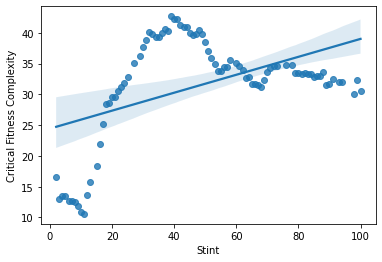

In [34]:
sns.regplot(
    y=dx["Critical Fitness Complexity"].rolling(6, center=False, min_periods=1).mean(),
    # y=data["Fitness Differential Focal"],
    x=dx["Stint"],
)


<AxesSubplot:xlabel='Stint', ylabel='Fitness Differential Focal'>

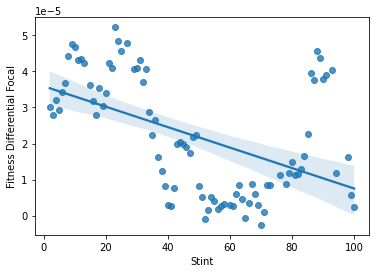

In [35]:
sns.regplot(
    y=dx["Fitness Differential Focal"].iloc[::-1].rolling(7, center=False, min_periods=1).mean().iloc[::-1],
    # y=data["Fitness Differential Focal"],
    x=dx["Stint"],
)


<AxesSubplot:xlabel='Stint'>

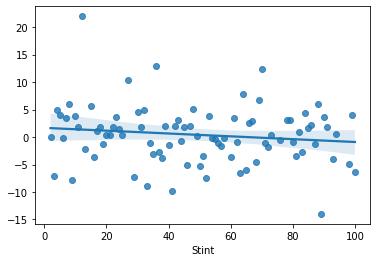

In [36]:
sns.regplot(
    x=dx["Stint"],
    y=dx["Critical Fitness Complexity"] - dx["prevcplx"],
)


MannwhitneyuResult(statistic=1005.0, pvalue=0.3658157173436481)
MannwhitneyuResult(statistic=1145.0, pvalue=0.040783873586806046)


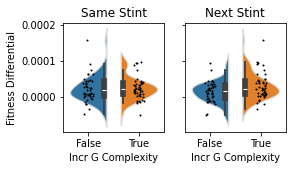

<AxesSubplot:xlabel='None', ylabel='Fitness Differential Focal'>

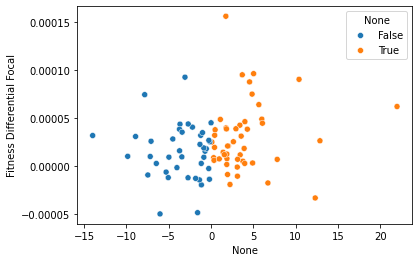

In [37]:
from scipy import stats as scipy_stats

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4,2), sharey=True)
for shift, ax in ((0, ax1), (-1, ax2)):
    cpx = dx["Critical Fitness Complexity"] - dx["prevcplx"] > 0
    fit = dx["Fitness Differential Focal"].shift(shift)

    sns.violinplot(
        x=cpx,
        hue=cpx,
        y=fit,
        inner="box",
        gap=0.1,
        split=True,
        legend=False,
        ax=ax,
    )
    ax.collections[1].set_edgecolor('gainsboro')
    ax.collections[0].set_edgecolor('gainsboro')
    sns.stripplot(
        x=cpx,
        y=fit,
        ax=ax,
        color="black",
        s=2,
    )
    ax.set_xlabel("Incr G Complexity")
    ax.set_ylabel("Fitness Differential")

    print(
        scipy_stats.mannwhitneyu(
            fit[cpx].dropna(),
            fit[~cpx].dropna(),
            alternative="greater",
        ),
    )

ax1.set_title("Same Stint")
ax2.set_title("Next Stint")

plt.show()

sns.scatterplot(
    x=dx["Critical Fitness Complexity"] - dx["prevcplx"],
    y=dx["Fitness Differential Focal"].shift(shift),
    hue=cpx,
)


teeplots/2025-08-28-complexity-adaptation/how=rollingmean+sign=1+viz=subplots+ext=.pdf
teeplots/2025-08-28-complexity-adaptation/how=rollingmean+sign=1+viz=subplots+ext=.png


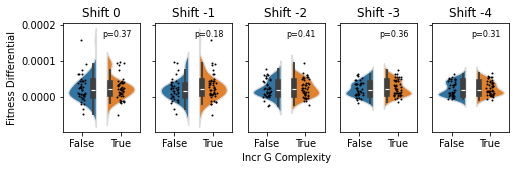

teeplots/2025-08-28-complexity-adaptation/how=rollingmean+sign=-1+viz=subplots+ext=.pdf
teeplots/2025-08-28-complexity-adaptation/how=rollingmean+sign=-1+viz=subplots+ext=.png


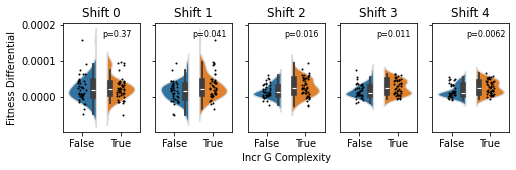

In [38]:
from scipy import stats as scipy_stats

for sign in 1, -1:
    with tp.teed(
        plt.subplots,
        1, 5, figsize=(8,2), sharey=True,
        teeplot_outattrs={
            "sign": sign,
            "how": "rollingmean",
        },
        teeplot_subdir=teeplot_subdir,
    ) as g:
        fig, axs = g
        for shift, ax in zip(range(10), axs):
            cpx = dx["Critical Fitness Complexity"] - dx["prevcplx"] > 0
            if shift:
                fit = dx["Fitness Differential Focal"].iloc[::sign].rolling(shift, center=False, closed="left", min_periods=1).mean().iloc[::sign]
            else:
                fit = dx["Fitness Differential Focal"]

            sns.violinplot(
                x=cpx,
                hue=cpx,
                y=fit,
                inner="box",
                gap=0.1,
                split=True,
                legend=False,
                ax=ax,
            )
            ax.collections[1].set_edgecolor('gainsboro')
            ax.collections[0].set_edgecolor('gainsboro')
            sns.stripplot(
                x=cpx,
                y=fit,
                ax=ax,
                color="black",
                s=2,
            )
            ax.set_xlabel("Incr G Complexity")
            ax.set_ylabel("Fitness Differential")
            p = scipy_stats.mannwhitneyu(
                fit[cpx].dropna(),
                fit[~cpx].dropna(),
                alternative="greater",
            ).pvalue
            ax.text(0.7, 0.9, f"p={p:.2g}",
                    ha='center', va='center',
                    fontsize=8,
                    transform=ax.transAxes,
                )
            if shift != 2:
                ax.set_xlabel("")

            ax.set_title(f"Shift {-1 * sign * shift}")


teeplots/2025-08-28-complexity-adaptation/how=shift+sign=1+viz=subplots+ext=.pdf
teeplots/2025-08-28-complexity-adaptation/how=shift+sign=1+viz=subplots+ext=.png


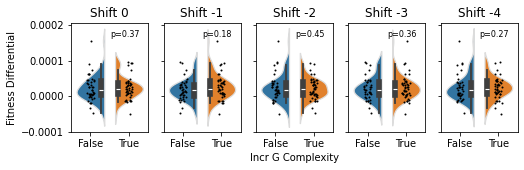

teeplots/2025-08-28-complexity-adaptation/how=shift+sign=-1+viz=subplots+ext=.pdf
teeplots/2025-08-28-complexity-adaptation/how=shift+sign=-1+viz=subplots+ext=.png


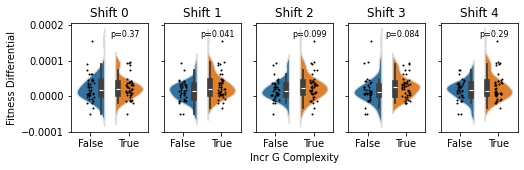

In [39]:
from scipy import stats as scipy_stats

for sign in 1, -1:
    with tp.teed(
        plt.subplots,
        1, 5, figsize=(8,2), sharey=True,
        teeplot_outattrs={
            "sign": sign,
            "how": "shift",
        },
        teeplot_subdir=teeplot_subdir,
    ) as g:
        fig, axs = g
        for shift, ax in zip(range(10), axs):
            cpx = dx["Critical Fitness Complexity"] - dx["prevcplx"] > 0
            if shift:
                fit = dx["Fitness Differential Focal"].shift(sign * shift)

            else:
                fit = dx["Fitness Differential Focal"]

            sns.violinplot(
                x=cpx,
                hue=cpx,
                y=fit,
                inner="box",
                gap=0.1,
                split=True,
                legend=False,
                ax=ax,
            )
            ax.collections[1].set_edgecolor('gainsboro')
            ax.collections[0].set_edgecolor('gainsboro')
            sns.stripplot(
                x=cpx,
                y=fit,
                ax=ax,
                color="black",
                s=2,
            )
            ax.set_xlabel("Incr G Complexity")
            ax.set_ylabel("Fitness Differential")
            p = scipy_stats.mannwhitneyu(
                fit[cpx].dropna(),
                fit[~cpx].dropna(),
                alternative="greater",
            ).pvalue
            ax.text(0.7, 0.9, f"p={p:.2g}",
                    ha='center', va='center',
                    fontsize=8,
                    transform=ax.transAxes,
                )

            if shift != 2:
                ax.set_xlabel("")

            ax.set_title(f"Shift {-1 * sign * shift}")
